In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd


In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import sessionmaker, scoped_session

In [5]:
#Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
#Create Engine Connection
conn = engine.connect()


In [6]:
# reflect an existing database into a new model
Base.prepare(engine, reflect = True)
# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [7]:
# We can view all of the classes that automap found (use inspector)
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [8]:
#View columns in measurement class
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
#View columns in station class
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
print(Measurement)

<class 'sqlalchemy.ext.automap.measurement'>


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
#display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x157f2372ec8>,
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397'}

In [13]:
#Select only a couple rows from table and print
for row in session.query(Measurement.date, Measurement.prcp).limit(15).all():
    print(row)

('2010-01-01', 0.08)
('2010-01-02', 0.0)
('2010-01-03', 0.0)
('2010-01-04', 0.0)
('2010-01-06', None)
('2010-01-07', 0.06)
('2010-01-08', 0.0)
('2010-01-09', 0.0)
('2010-01-10', 0.0)
('2010-01-11', 0.01)
('2010-01-12', 0.0)
('2010-01-14', 0.0)
('2010-01-15', 0.0)
('2010-01-16', 0.0)
('2010-01-17', 0.0)


# Exploratory Climate Analysis

In [14]:
#calculate the date 1 year ago from the last data point in the database
#import timedelta for date calculations
from datetime import timedelta
#save last date and cast it as a date
last_date = dt.date(2017, 8, 23)
#save 365 days to do math with dates in date format
three_six_five_days = (dt.timedelta(days=365))
#save one year ago's date
year_ago_date = last_date - three_six_five_days
print(year_ago_date)





2016-08-23


In [15]:
#Design a query to retrieve the last 12 months of precipitation data and plot the results
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>year_ago_date).all()


(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 <a list of 7 Text xticklabel objects>)

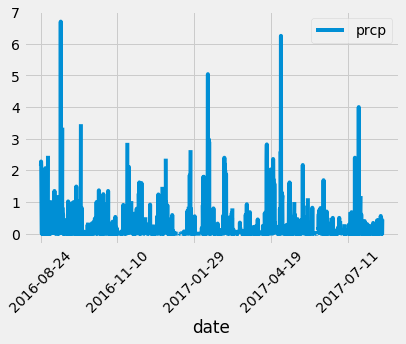

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(data,columns=["date","prcp"])

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot("date","prcp")
plt.xticks(rotation=45)

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [43]:
# Design a query to show how many stations are available in this dataset?
totalstations = session.query(func.count(Station.station)).all()
print(totalstations)

[(9,)]


In [44]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activestations = session.query(func.count(Measurement.station),Measurement.station).group_by(Measurement.station).order_by\
    (func.count(Measurement.station).desc()).all()
print(activestations)

[(2772, 'USC00519281'), (2724, 'USC00519397'), (2709, 'USC00513117'), (2669, 'USC00519523'), (2612, 'USC00516128'), (2202, 'USC00514830'), (1979, 'USC00511918'), (1372, 'USC00517948'), (511, 'USC00518838')]


In [36]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
combinedquery = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station=="USC00519281").all()
minquery = session.query(func.min(Measurement.tobs)).all()
maxquery = session.query(func.max(Measurement.tobs)).all()
avgquery = session.query(func.avg(Measurement.tobs)).all()
print(combinedquery)

[(54.0, 85.0, 71.66378066378067)]


In [46]:
##Count the number of temperature observations by station
total_obs_per_station = session.query(func.count(Measurement.tobs),Measurement.station).group_by(Measurement.station).all()
print(total_obs_per_station)

[(1979, 'USC00511918'), (2709, 'USC00513117'), (2202, 'USC00514830'), (2612, 'USC00516128'), (1372, 'USC00517948'), (511, 'USC00518838'), (2772, 'USC00519281'), (2724, 'USC00519397'), (2669, 'USC00519523')]


In [54]:
# Choose the station with the highest number of temperature observations.
#USC00519281
data = session.query(Measurement.station).filter(Measurement.station=="USC00519281").all()
print(data)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.tobs).filter(Measurement.date>=year_ago_date).all()


[('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC00519281',), ('USC0051

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [26]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [29]:
# Plot the daily normals as an area plot with `stacked=False`
